In [2]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================
import plot_data as pt
import scipy_optimizer as sp_opt

In [3]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [4]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(3)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [5]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    tau_1 = Paras_global[1]
    tau_2 = Paras_global[2]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    # qml.PhaseDamping(gamma_dephase, wires = 0)
    # qml.PhaseDamping(gamma_dephase, wires = 1)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    # qml.PhaseDamping(gamma_dephase, wires = 0)
    # qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H, phi, 1)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1])

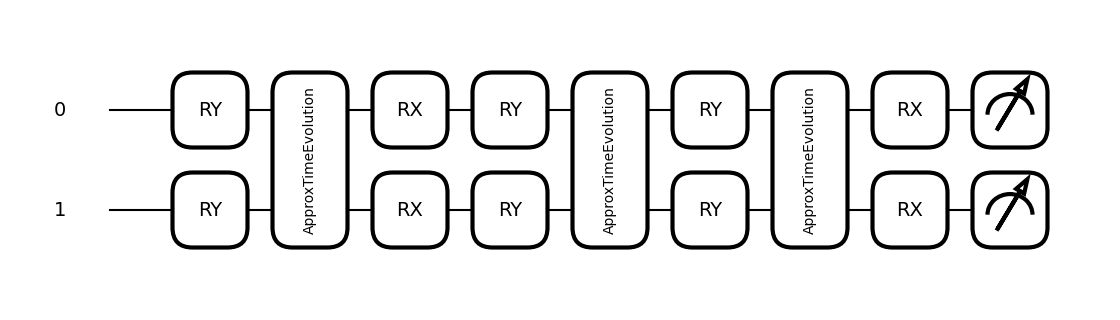

In [6]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [7]:
@qml.qnode(dev)
def Post_selection(phi):
    """
    Applies post-selection to the output of the circuit function using a Kraus operator. 
    It returns the updated density matrix.

    Args:
        phi (float): A phase parameter for the quantum circuit.

    Returns:
        array: The post-selected density matrix of the qubit.
    """
    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.array([
        [pnp.sqrt(1 - Gamma_ps_global), 0],
        [0, 1]
    ])

    Numerator = pnp.kron(K, pnp.eye(2)) @ get_density_matrix @ pnp.kron(K, pnp.eye(2)).conj().T
    Denominator = pnp.trace(Numerator)
    rho_ps = Numerator / Denominator

    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1]) 

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})]}
$$

In [8]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [9]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [10]:
def scipy_optimization(sweep_range, initial_parameters, method, gamma_ps_idx, tau_idx):
    """
    Performs optimization over a range of Phi values using different methods 
    from SciPy's optimization library.

    Args:
        sweep_range (tuple): Range of Phi values.
        initial_parameters (array): Initial guess for the parameters.
        method (str): Optimization method.
        gamma_ps_idx (float): Index for gamma post-selection.
        tau_idx (float): Index for tau.

    Returns:
        ndarray: A data array containing the optimization results for each Phi value.
    """
    Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
    Data = np.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    gradient = grad(cost_function)
    hessian = jacobian(gradient)
    
    global Phi_global
    paras_temporary = initial_parameters

    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)
        
        # N = int(phi_current / np.pi) * np.pi
        # if gamma_ps_idx == 8e-1:
        #     if tau_idx == 0:
        #         paras_temporary = pnp.array([np.pi/2, np.pi/2])

        #     elif (np.pi/2 + N <= phi_current <= 2.1 + N):
        #         paras_temporary = pnp.array([np.pi/2, 1])
        
        constraints = sp_opt.get_constraints(len(initial_parameters), phi_current, gamma_ps_idx, tau_idx)
        
        if method == 'LBFGSB':
            opt_result = sp_opt.lbfgsb(cost_function, paras_temporary, constraints, gradient)
        
        elif method == 'SLSQP':
            opt_result = sp_opt.slsqp(cost_function, paras_temporary, constraints, gradient)
        
        elif method == 'trust_constr':
            opt_result = sp_opt.trust_constr(cost_function, paras_temporary, constraints, gradient, hessian)

        else:
            raise ValueError("Invalid optimizer choice.") 
    
        print("CFI =", -opt_result.fun, "Paras =", opt_result.x)
        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x
        
    return Data

In [11]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
    """
    Runs the optimization for different values of tau_dephase.

    Args:
        sweep_range (tuple): Range of Phi values.
        init_par (array): Initial parameters for optimization.
        tau_dephase (list): List of tau dephasing values.
        gamma_post_selection (float): Gamma value for post-selection.
        method (str): Optimization method to use.

    Returns:
        ndarray: A multidimensional array with optimization data for each tau value.
    """
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = scipy_optimization(sweep_range, init_par, method, gamma_post_selection, tau_current)
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [12]:
sweep_range = np.array([0.0, 3*np.pi, 1e-2])
init_par = pnp.array([np.pi/2, np.pi/2, np.pi/2])
tau_dephase = 0,
gamma_ps = 0.8

res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGSB')

CFI = 6.787629348401803e-07 Paras = [1.57079633 1.57079633 1.57079633]
CFI = 5.9999998063330535 Paras = [1.57079632 4.70213366 1.57079632]
CFI = 1.337273922792612 Paras = [1.57079633 4.69233644 1.57079633]
CFI = 5.544060360925916 Paras = [1.57079633 4.68240036 1.57079633]
CFI = 5.9999987491969 Paras = [1.57079633 4.67237312 1.57079632]
CFI = 5.999969578402786 Paras = [1.57079633 4.66064473 1.57079633]
CFI = 5.999985900828264 Paras = [1.57079637 4.65120304 1.57079628]
CFI = 6.000000802806039 Paras = [1.57079633 4.64233743 1.57079632]
CFI = 5.9999682030319015 Paras = [1.57079634 4.6306057  1.57079631]
CFI = 6.000001897268964 Paras = [1.57079633 4.62219433 1.57079632]
CFI = 5.999998811185421 Paras = [1.57079633 4.61202762 1.57079633]
CFI = 0.5140929373078662 Paras = [1.57079632 4.60223798 1.57079634]
CFI = 5.999994585198644 Paras = [1.57079633 4.59312621 1.57079633]
CFI = 5.999990781512979 Paras = [1.57079633 4.58334978 1.57079633]
CFI = 5.99999778482119 Paras = [1.57079633 4.57190788 1.5

KeyboardInterrupt: 

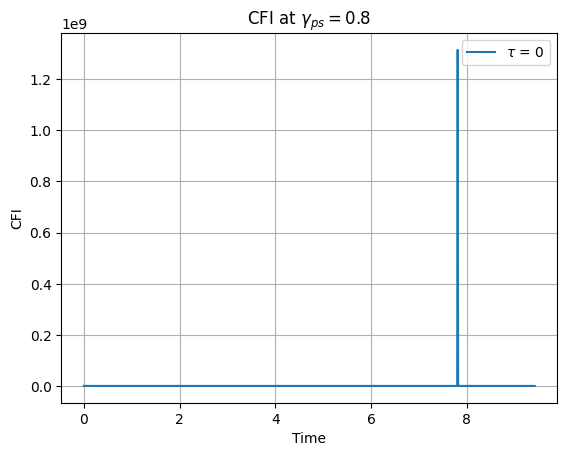

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'CFI')

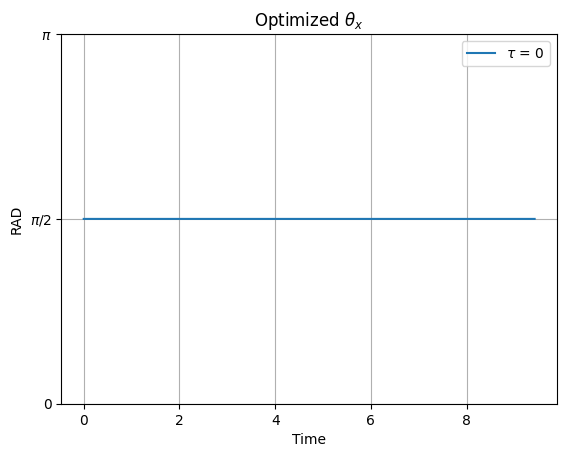

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'theta_x')

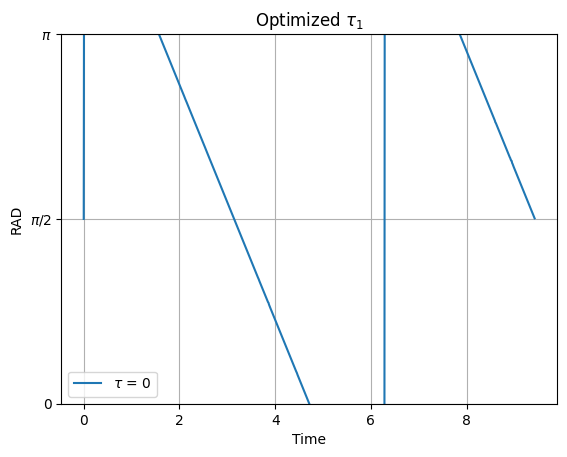

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'tau_1')

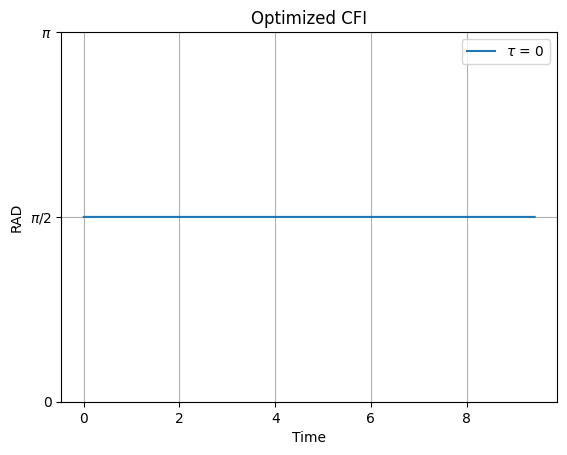

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'tau_2')